# Sistema de detección de minas utilizando GPR y CNN

## Importaciones

In [ ]:
import joblib
import h5py
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import SGD


## Funciones

### Lectura de C-scans

In [ ]:
def read_c_scan(filename: str, polarization: str):
    data_frame = h5py.File(filename, 'r')

    t0 = data_frame['Time'].attrs['t0']
    tf = data_frame['Time'].attrs['tf']
    qt = int(data_frame['Time'].attrs['q'])
    # x- and y-axis lower limits, upper limits and step are retrieved
    x0 = data_frame['Position'].attrs['x0']
    dx = data_frame['Position'].attrs['dx']
    xf = data_frame['Position'].attrs['xf']
    y0 = data_frame['Position'].attrs['y0']
    dy = data_frame['Position'].attrs['dy']
    yf = data_frame['Position'].attrs['yf']
    print(f"x: ({x0}, {xf})")
    print(f"y: ({y0}, {yf})")
    # Amount of steps over each axis is calculated. Operation rounds up the division result as needed
    qx = int(round((xf - x0) / dx + 1))
    qy = int(round((yf - y0) / dy + 1))

    c_scan_scalars = np.zeros([qx, qy, qt])

    for i in range(0, qx):
        # Indexes used to retrieve individual planes of the C-Scan are calculated
        index_0 = i * qy
        index_f = (i + 1) * qy
        c_scan_scalars[i, :, :] = data_frame['A-Scan/Re{A-Scan x-pol}'][index_0:index_f][:]

    return c_scan_scalars

### Obtener canales


In [ ]:
class DataGenerator(Sequence):
    
  def __init__(self, c_scan, y):
    self.c_scan = c_scan
    self.qx, self.qy, self.qt = c_scan.shape
    self.y = y
  
  def __len__(self):
    #return self.qx * self.qy
    return self.qx

  def __getitem__(self, idx):
    n_samples = self.qy
    n_channels = 2
    X = np.zeros((n_samples, self.qx, self.qt, n_channels))
    #i, j = idx // self.qx, idx % self.qy
    i = idx
    for j in range(n_samples):
      X[j,:,:,0] = self.c_scan[i,:,:]
      X[j,:,:,1] = self.c_scan[:,j,:]
    idx_s, idx_f = i*141, i*141 + n_samples
    y = np.reshape(self.y[idx_s: idx_f], (-1, 1))
    return X, y

  def get_samples(self):
    return self.qx * self.qy


In [ ]:
class DataGenerator(Sequence):
    
  def __init__(self, filenames, y, shuffle = False):
    self.n_c_scans = len(filenames)
    self.c_scans = c_scan
    self.qx, self.qy, self.qt = c_scan.shape
    self.y = y
  
  def __len__(self):
    return self.n_c_scans * self.qx

  def __getitem__(self, idx):
    n_samples = self.qy
    n_channels = 2
    n_c_scan = idx // n_c_scans
    c_scan
    X = np.zeros((n_samples, self.qx, self.qt, n_channels))
    #i, j = idx // self.qx, idx % self.qy
    i = idx
    for j in range(n_samples):
      X[j,:,:,0] = c_scan[i,:,:]
      X[j,:,:,1] = c_scan[:,j,:]
    idx_s, idx_f = i*141, i*141 + n_samples
    y = np.reshape(self.y[idx_s: idx_f], (-1, 1))
    return X, y

  def get_samples(self):
    return self.n_c_scans * self.qx * self.qy


In [ ]:
def get_channels(c_scan):
  qx, qy, qt = c_scan.shape
  ans = np.zeros((qx*qy, qy, qt, 2))
  for i, j in itertools.product(range(qx), range(qy)):
    ans[i*j, :, :, 1] = c_scan[i,:,:]
    ans[i*j, :, :, 2] = c_scan[:,j,:]
  return ans

### Graficar mapa de minas

In [ ]:
def plot_mine_map(x, y, map):
    plt.figure(figsize=(10, 10))
    plt.grid(False)
    plt.pcolor(x, y, np.swapaxes(map, 0, 1), cmap='YlGnBu')
    plt.colorbar()
    plt.clim(0,1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

## Escenarios 

### Escenario 1

x: (0.0, 0.7)
y: (0.0, 0.7)


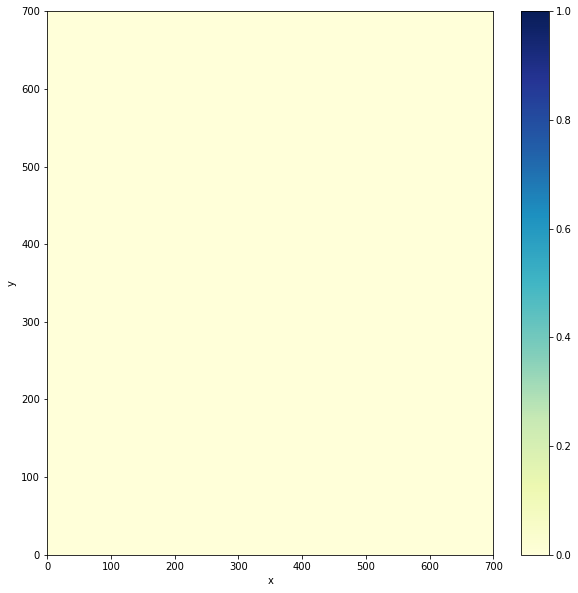

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_1.h5", 'x')
qx, qy, qt = c_scan.shape



x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((qx, qy))
y_1 = np.reshape(mine_map, (qx * qy))
train_generator_1 = DataGenerator(c_scan, y_1)

plot_mine_map(x, y, mine_map)

### Escenario 2

x: (0.0, 0.7)
y: (0.0, 0.7)


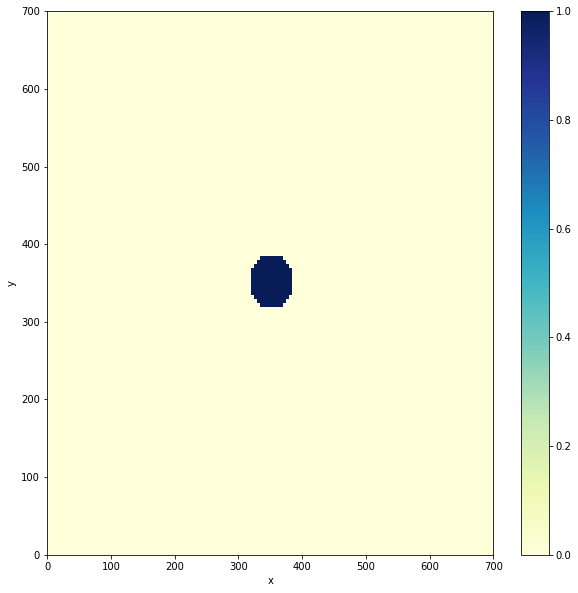

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_2.h5", 'x')

qx, qy, qt = c_scan.shape
X_2 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx = 350
cy = 350
r = 35

mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

y_2 = np.reshape(mine_map, (qx * qy))
train_generator_2 = DataGenerator(c_scan, y_2)
plot_mine_map(x, y, mine_map)


### Escenario 3

x: (0.0, 0.7)
y: (0.0, 0.7)


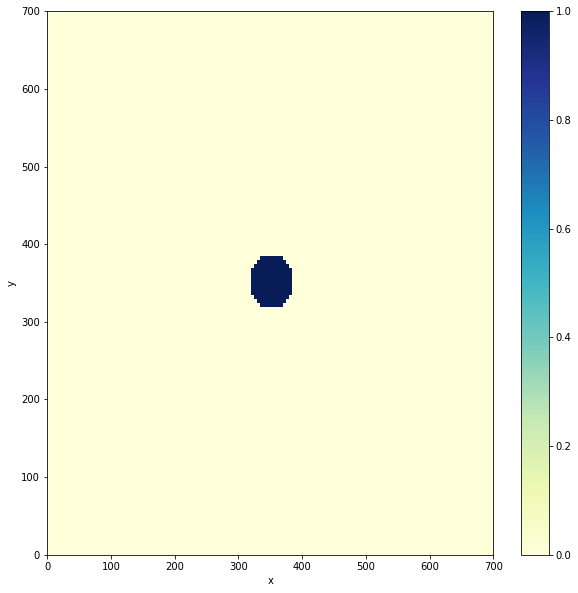

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_3.h5", "x")
qx, qy, qt = c_scan.shape
X_3 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx = 350
cy = 350
r = 35

mask = (x[:, np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

y_3 = np.reshape(mine_map, (qx * qy))
train_generator_3 = DataGenerator(c_scan, y_3)

plot_mine_map(x, y, mine_map)

### Escenario 4

x: (0.0, 0.7)
y: (1.0, 1.7)


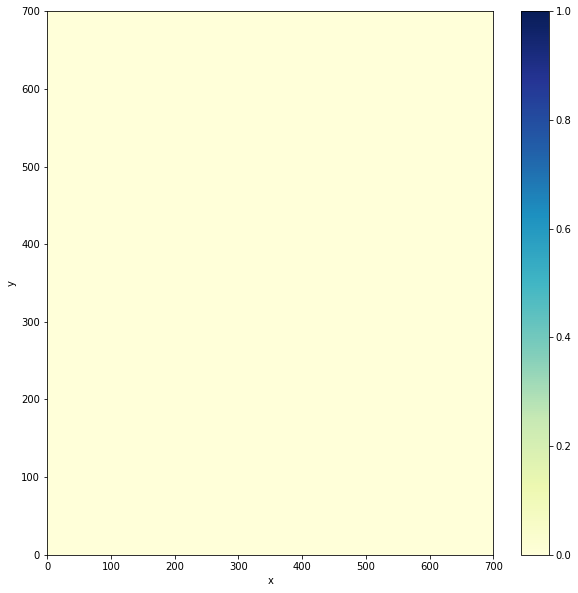

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_4.h5", 'x')
qx, qy, qt = c_scan.shape
X_4 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

y_4 = np.reshape(mine_map, (qx * qy))
train_generator_4 = DataGenerator(c_scan, y_4)

plot_mine_map(x, y, mine_map)

### Escenario 5

x: (0.0, 0.7)
y: (0.0, 0.7)


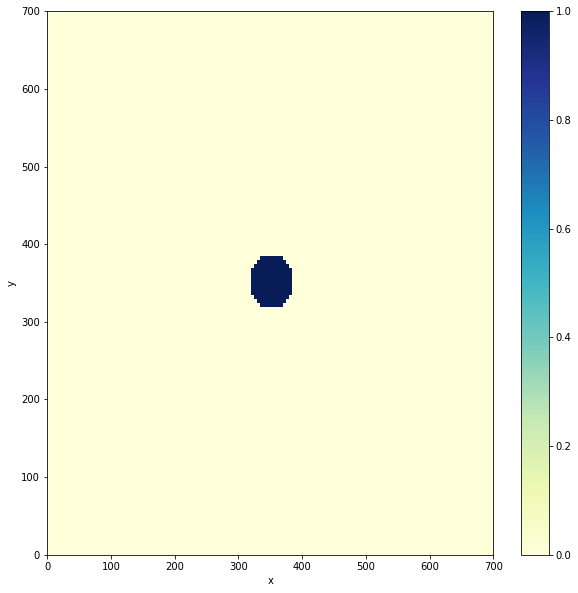

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_5.h5", 'x')

qx, qy, qt = c_scan.shape
X_5 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx = 350
cy = 350
r = 35

mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

y_5 = np.reshape(mine_map, (qx * qy))
train_generator_5 = DataGenerator(c_scan, y_5)


plot_mine_map(x, y, mine_map)

### Escenario 6

x: (0.0, 0.7)
y: (1.0, 1.7)


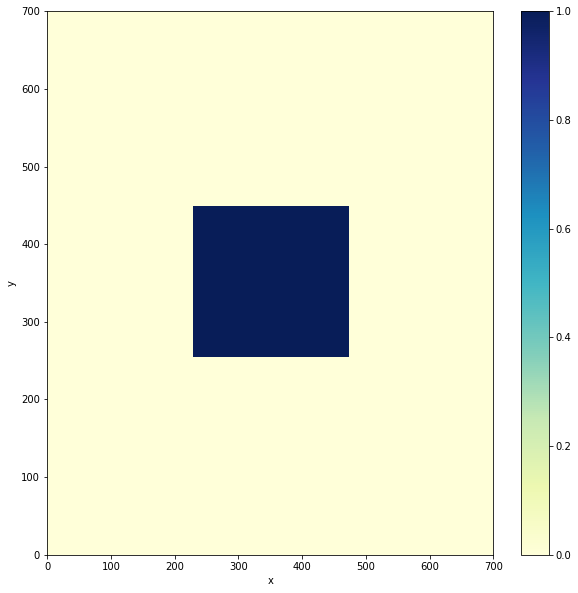

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_6.h5", 'x')

qx, qy, qt = c_scan.shape
X_6 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx = 350
cy = 350
l = 250

mask_x= np.abs(x-cx) < 200/2.
mask_y= np.abs(y-cy) < 250/2

mine_map[np.ix_(np.flatnonzero(mask_x), np.flatnonzero(mask_y))] = 1

y_6 = np.reshape(mine_map, (qx * qy))
train_generator_6 = DataGenerator(c_scan, y_6)


plot_mine_map(x, y, mine_map)

### Escenario 7

x: (0.0, 0.7)
y: (0.0, 0.7)


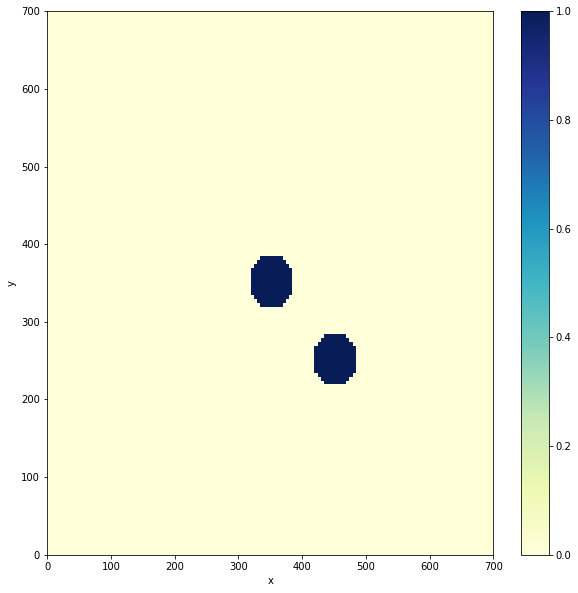

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_7.h5", 'x')

qx, qy, qt = c_scan.shape
X_7 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx, cy, r = 350, 350, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, r = 450, 250, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

y_7 = np.reshape(mine_map, (qx * qy))
train_generator_7 = DataGenerator(c_scan, y_7)


plot_mine_map(x, y, mine_map)

### Escenario 8

x: (0.0, 0.7)
y: (1.0, 1.7)


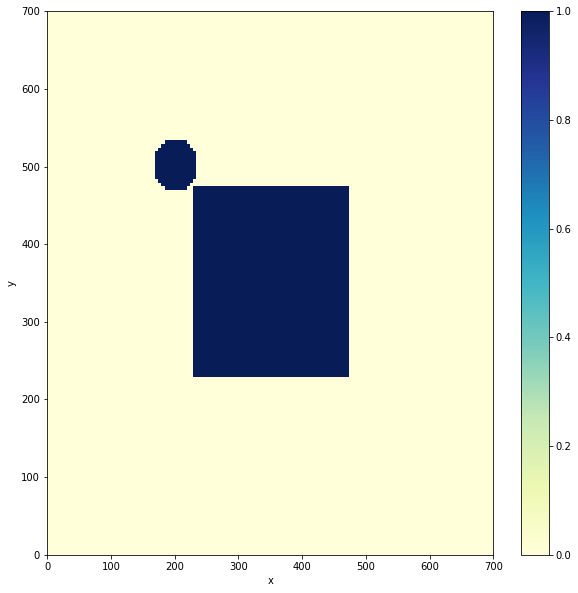

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_8.h5" ,"x")
qx, qy, qt = c_scan.shape
X_8 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)
mine_map = np.zeros((x.size, y.size))

cx, cy, r = 200, 500, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, l = 350, 350, 250
mask_x= np.abs(x-cx) < 200/2
mask_y= np.abs(y-cy) < 250/2

mine_map[np.ix_(np.flatnonzero(mask_x), np.flatnonzero(mask_y))] = 1

y_8 = np.reshape(mine_map, (qx * qy))
train_generator_8 = DataGenerator(c_scan, y_8)

plot_mine_map(x, y, mine_map)

### Escenario 11

x: (0.0, 0.7)
y: (0.0, 0.7)


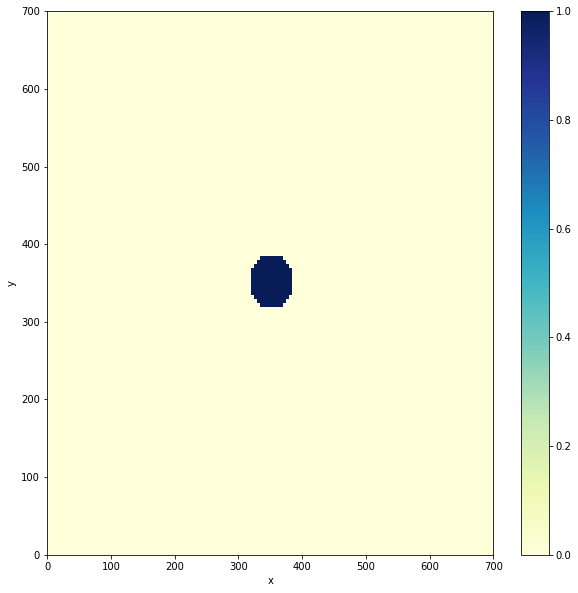

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_11.h5", 'x')

qx, qy, qt = c_scan.shape
X_11 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx = 350
cy = 350
r = 35

mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

y_11 = np.reshape(mine_map, (qx * qy))
train_generator_11 = DataGenerator(c_scan, y_11)


plot_mine_map(x, y, mine_map)

## Entrenamiento

### Unión de Escenarios

In [ ]:
#X_train = np.concatenate((X_2, X_3, X_5, X_6), axis=0)
y_train = np.concatenate((y_2, y_3, y_5, y_6), axis=0)
#print(f"Número de muestras sin objeto: {y_train[y_train == 0].shape[0]}")
print(f"Número de muestras con objeto: {y_train[y_train == 1].shape[0]}")

Número de muestras sin objeto: 76688
Número de muestras con objeto: 2836


In [ ]:
X_val = np.concatenate((X_4, X_8), axis=0)
y_val = np.concatenate((y_4, y_8), axis=0)

### CNN





In [ ]:
n_a_scans = 141
n_time_steps = 555
n_channels = 2

model = Sequential()
# Batch Normalization
model.add(BatchNormalization(input_shape=(n_a_scans, n_time_steps, n_channels)))
# First Convolutional Layer
model.add(Conv2D(filters=16, kernel_size = (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

#model.add(Conv2D(filters=32, kernel_size = (3, 3), strides=2, activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
# Second Convolutional Latyer
model.add(Conv2D(filters=32, kernel_size = (7, 7), strides=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())
# Dense layer 
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(1, activation='sigmoid'))
opt = SGD(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[tf.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 141, 555, 2)      8         
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 139, 553, 16)      304       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 46, 184, 16)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 89, 32)        25120     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 44, 32)       0         
 2D)                                                             
                                                      

In [ ]:
class_weight_2 = compute_class_weight(class_weight = 'balanced', classes = [0, 1], y = y_2)
class_weight_3 = compute_class_weight(class_weight = 'balanced', classes = [0, 1], y = y_3)
class_weight_5 = compute_class_weight(class_weight = 'balanced', classes = [0, 1], y = y_5)
class_weight_6 = compute_class_weight(class_weight = 'balanced', classes = [0, 1], y = y_6)
class_weight_7 = compute_class_weight(class_weight = 'balanced', classes = [0, 1], y = y_7)
class_weight_8 = compute_class_weight(class_weight = 'balanced', classes = [0, 1], y = y_8)
class_weight_11 = compute_class_weight(class_weight = 'balanced', classes = [0, 1], y = y_11)

for i in range(15):
  print(f"Iteration: {i}")
  training = model.fit(train_generator_2_g, epochs = 1, callbacks = [EarlyStopping(monitor='loss', patience=20)], verbose=1, class_weight={0:class_weight_2[0], 1: class_weight_2[1]})
  training = model.fit(train_generator_5, epochs = 1, callbacks = [EarlyStopping(monitor='loss', patience=20)], verbose=1, class_weight={0:class_weight_5[0], 1: class_weight_5[1]})
  training = model.fit(train_generator_7, epochs = 1, callbacks = [EarlyStopping(monitor='loss', patience=20)], verbose=1, class_weight={0:class_weight_7[0], 1: class_weight_7[1]})
  training = model.fit(train_generator_8, epochs = 1, callbacks = [EarlyStopping(monitor='loss', patience=20)], verbose=1, class_weight={0:class_weight_8[0], 1: class_weight_8[1]})
  training = model.fit(train_generator_11, epochs = 1, callbacks = [EarlyStopping(monitor='loss', patience=20)], verbose=1, class_weight={0:class_weight_11[0], 1: class_weight_11[1]})

Iteration: 0
141/141 [==============================] - 37s 262ms/step - loss: 0.6965 - binary_accuracy: 0.3656 - recall_1: 0.5448
Iteration: 1
141/141 [==============================] - 38s 267ms/step - loss: 0.6977 - binary_accuracy: 0.6518 - recall_1: 0.2759
Iteration: 2
141/141 [==============================] - 38s 268ms/step - loss: 0.6950 - binary_accuracy: 0.6684 - recall_1: 0.3517
Iteration: 3
141/141 [==============================] - 38s 266ms/step - loss: 0.7153 - binary_accuracy: 0.8600 - recall_1: 0.2690
Iteration: 4
141/141 [==============================] - 39s 272ms/step - loss: 0.6923 - binary_accuracy: 0.8231 - recall_1: 0.2552
Iteration: 5
141/141 [==============================] - 38s 271ms/step - loss: 0.6999 - binary_accuracy: 0.8130 - recall_1: 0.4828
Iteration: 6
141/141 [==============================] - 39s 274ms/step - loss: 0.5764 - binary_accuracy: 0.7796 - recall_1: 0.6828
Iteration: 7
141/141 [==============================] - 39s 273ms/step - loss: 0.39

Text(0, 0.5, 'Recall')

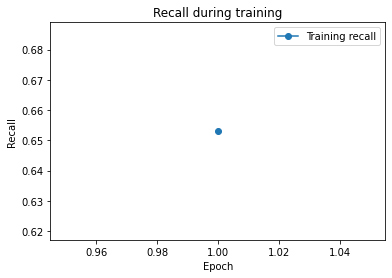

In [ ]:
t_span = range(1,len(training.history['recall_1'])+1)
# Learning process
plt.figure()
plt.plot(t_span,np.array(training.history['recall_1']), marker = 'o',label = 'Training recall')
#plt.plot(t_span,np.array(training.history['val_recall_6']),marker='o', label = 'Validation recall')
plt.title("Recall during training")
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Recall')

In [ ]:
model.save('cnn-2channels.h5')

## Evaluación

In [ ]:
qx, qy = 141, 141
x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

### Escenario 1

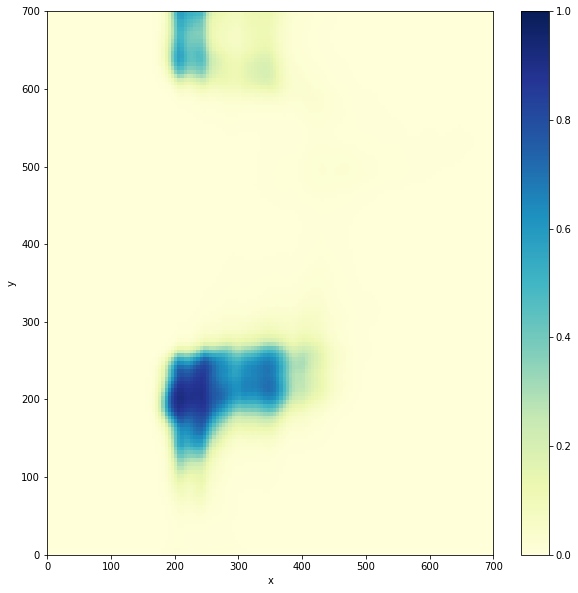

In [ ]:
mine_pred = model.predict(train_generator_1)
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 2

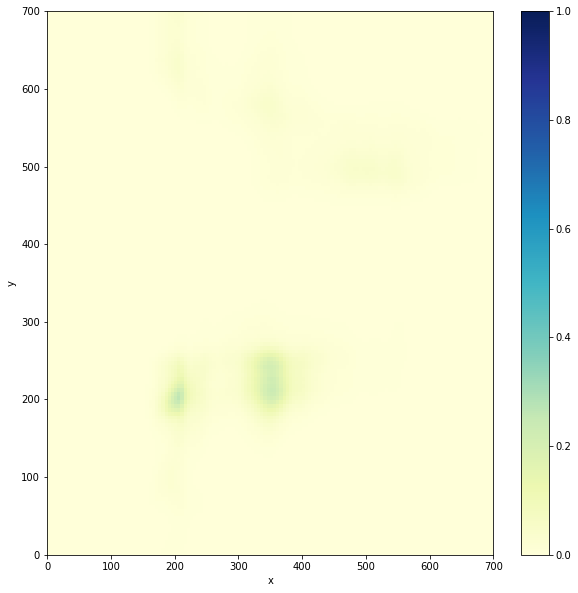

In [ ]:
mine_pred = model.predict(train_generator_2)
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 3

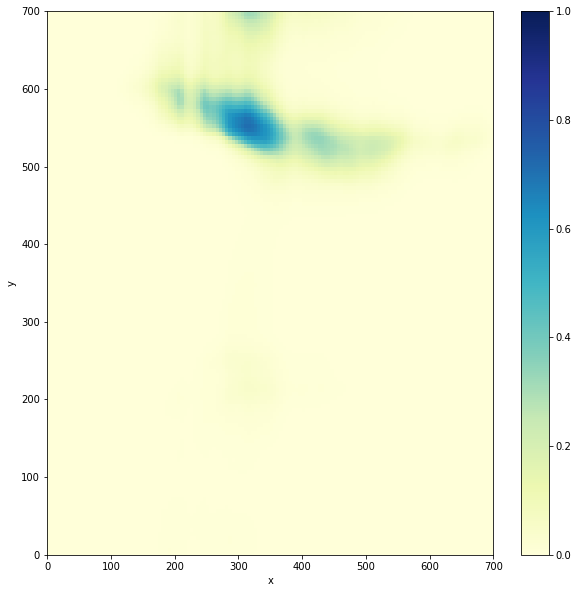

In [ ]:
mine_pred = model.predict(train_generator_3)
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 4

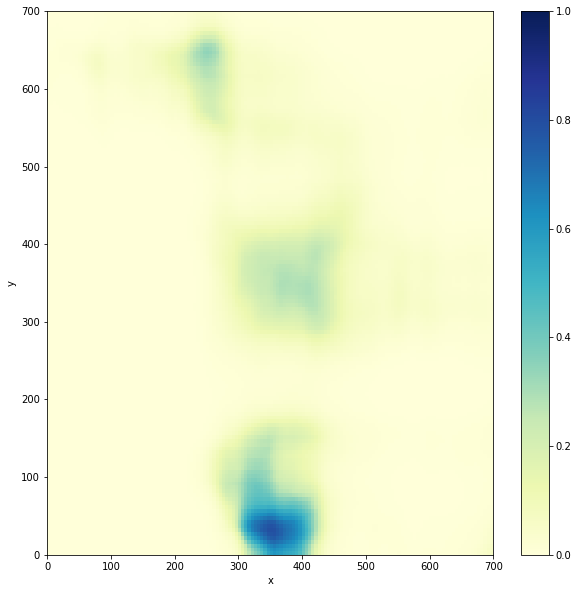

In [ ]:
mine_pred = model.predict(train_generator_4)
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 5

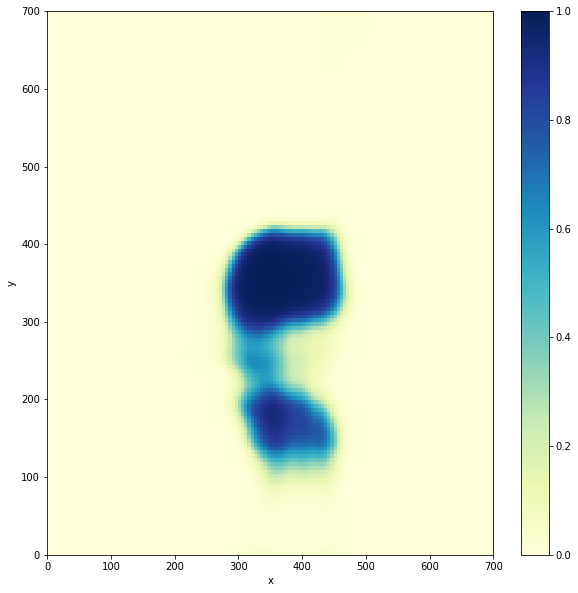

In [ ]:
mine_pred = model.predict(train_generator_5)
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 6

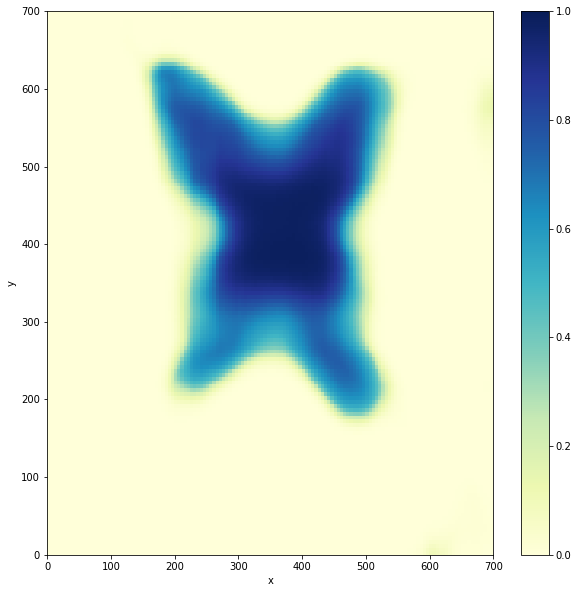

In [ ]:
mine_pred = model.predict(train_generator_6)
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 7

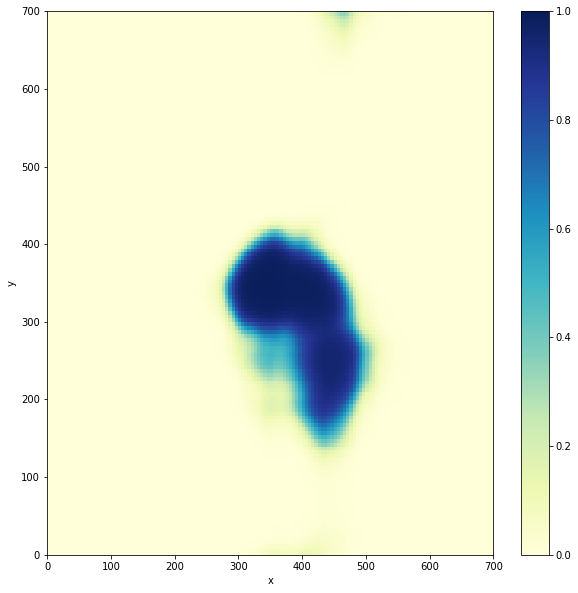

In [ ]:
mine_pred = model.predict(train_generator_7)
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 8

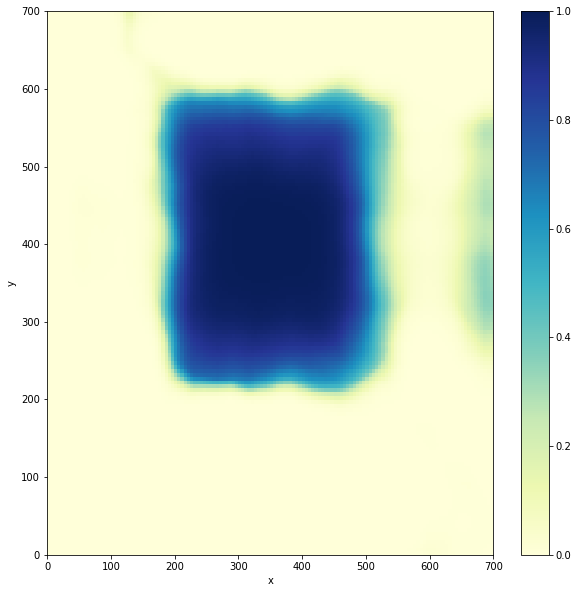

In [ ]:
mine_pred = model.predict(train_generator_8)
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 11

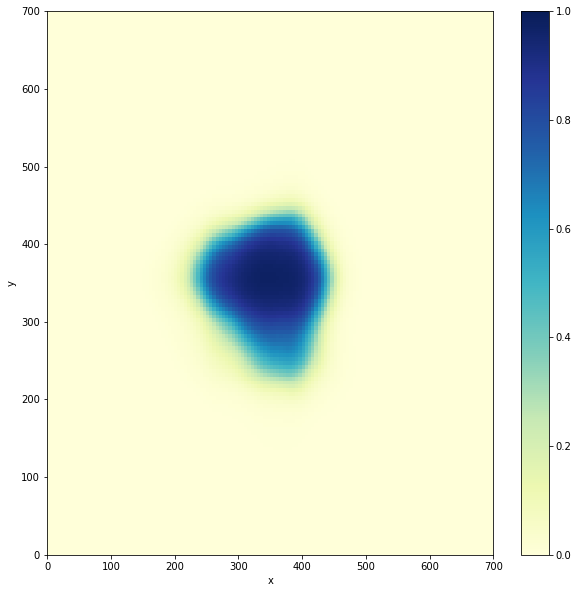

In [ ]:
mine_pred = model.predict(train_generator_11)
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

## Escenarios Gabriel

### Escenario 1



x: (0.0, 0.7)
y: (1.0, 1.7)


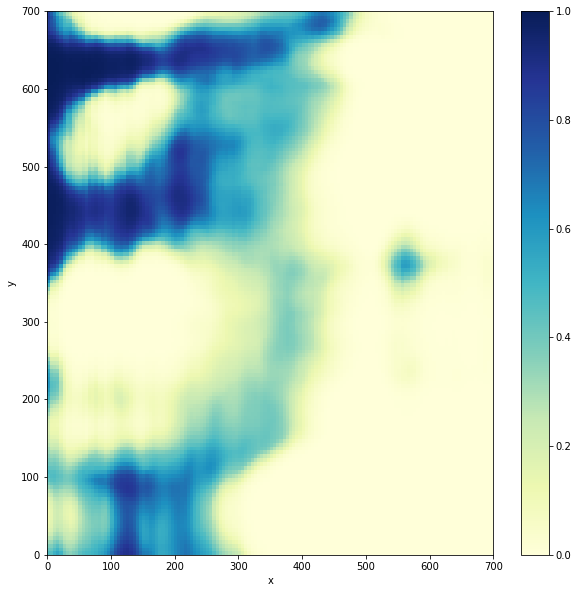

In [ ]:
c_scan = read_c_scan("C_scan_default_title_1.h5", 'x')
train_generator_1_g = DataGenerator(c_scan, y_1)
mine_pred = model.predict(train_generator_1_g)
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 2

x: (0.0, 0.7)
y: (0.0, 0.7)


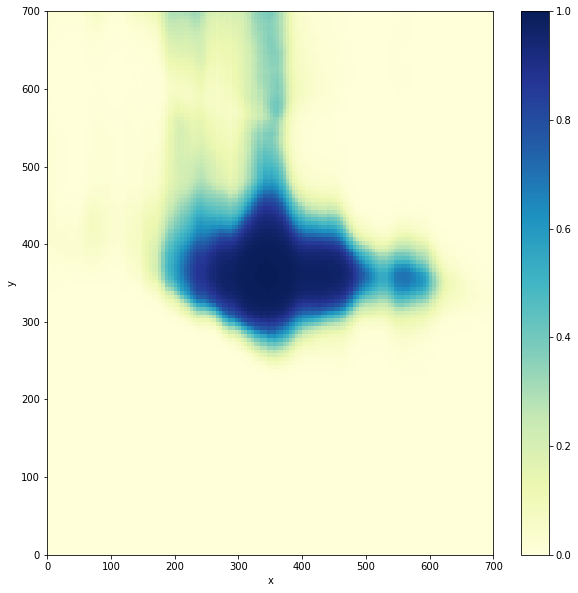

In [ ]:
c_scan = read_c_scan("C_scan_default_title_2.h5", 'x')
train_generator_2_g = DataGenerator(c_scan, y_2)
mine_pred = model.predict(train_generator_2_g)
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 3

x: (0.0, 0.7)
y: (0.0, 0.7)


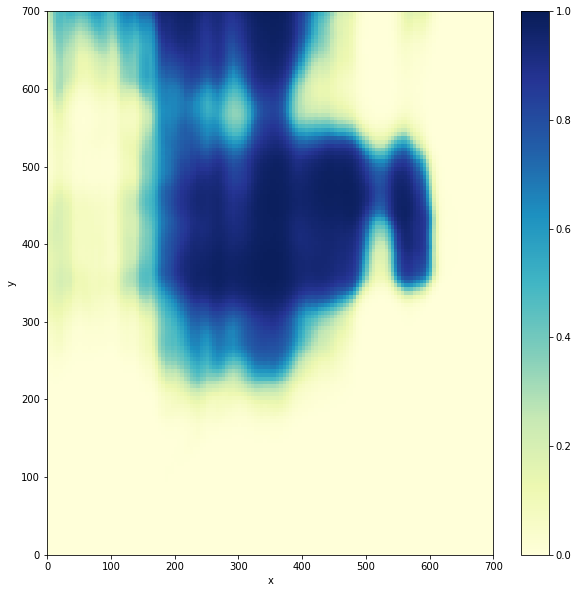

In [ ]:
c_scan = read_c_scan("C_scan_default_title_3.h5", 'x')
train_generator_3_g = DataGenerator(c_scan, y_3)
mine_pred = model.predict(train_generator_3_g)
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)